In [1]:
import numpy
import pandas
from src.data_objects import AllData
from src.functions import *
from src.readers import ReadDesign

retrain = False
runchain = False
logTrain = True

model_par = "input/epemDesign.txt"
ThisData = AllData
outdir = "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/"

Trimming points and obs ranges

In [2]:
del ThisData["Observables"]["PrPr2760"]
del ThisData["Observables"]["PrPr13000"]
ThisData["Design"] = ReadDesign("/data/rjfgroup/rjf01/cameron.parker/runs/LEPdesign/QVir_Analysis/parameters.txt")

trimRanges(ThisData)

In [3]:
badpoints = []
trimPoints(badpoints,ThisData)

Making Data pkl for selected observables

In [4]:
buildDataPkl(ThisData, logTrain)
print(ThisData["datapkl"])

temp-pkls/data.pkl


Getting emulators

In [5]:
from src.emulator_BAND import EmulatorBAND

if retrain:
    buildObsPkls(ThisData)
    trainEmulators(model_par, ThisData, logTrain)
else:
    readEmulators(ThisData)

Running Chain

In [6]:
from src.mcmc import Chain
import os

mymcmc = Chain(expdata_path=ThisData["datapkl"], model_parafile=model_par)
mymcmc.loadEmulator(getEmuPathList(ThisData))

[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from input/epemDesign.txt ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from temp-pkls/data.pkl ...
[INFO][mcmc] Experimental dataset size: 161
[INFO][mcmc] Number of Emulators: 5


In [7]:
os.environ["OMP_NUM_THREADS"] = "20"
# may have to: export RDMAV_FORK_SAFE=1 before running the code

n_effective=4000
n_active=2000
n_prior=8000
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 25000
n_evidence = 0

pool = 20

if runchain:
    sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

Corner Plot

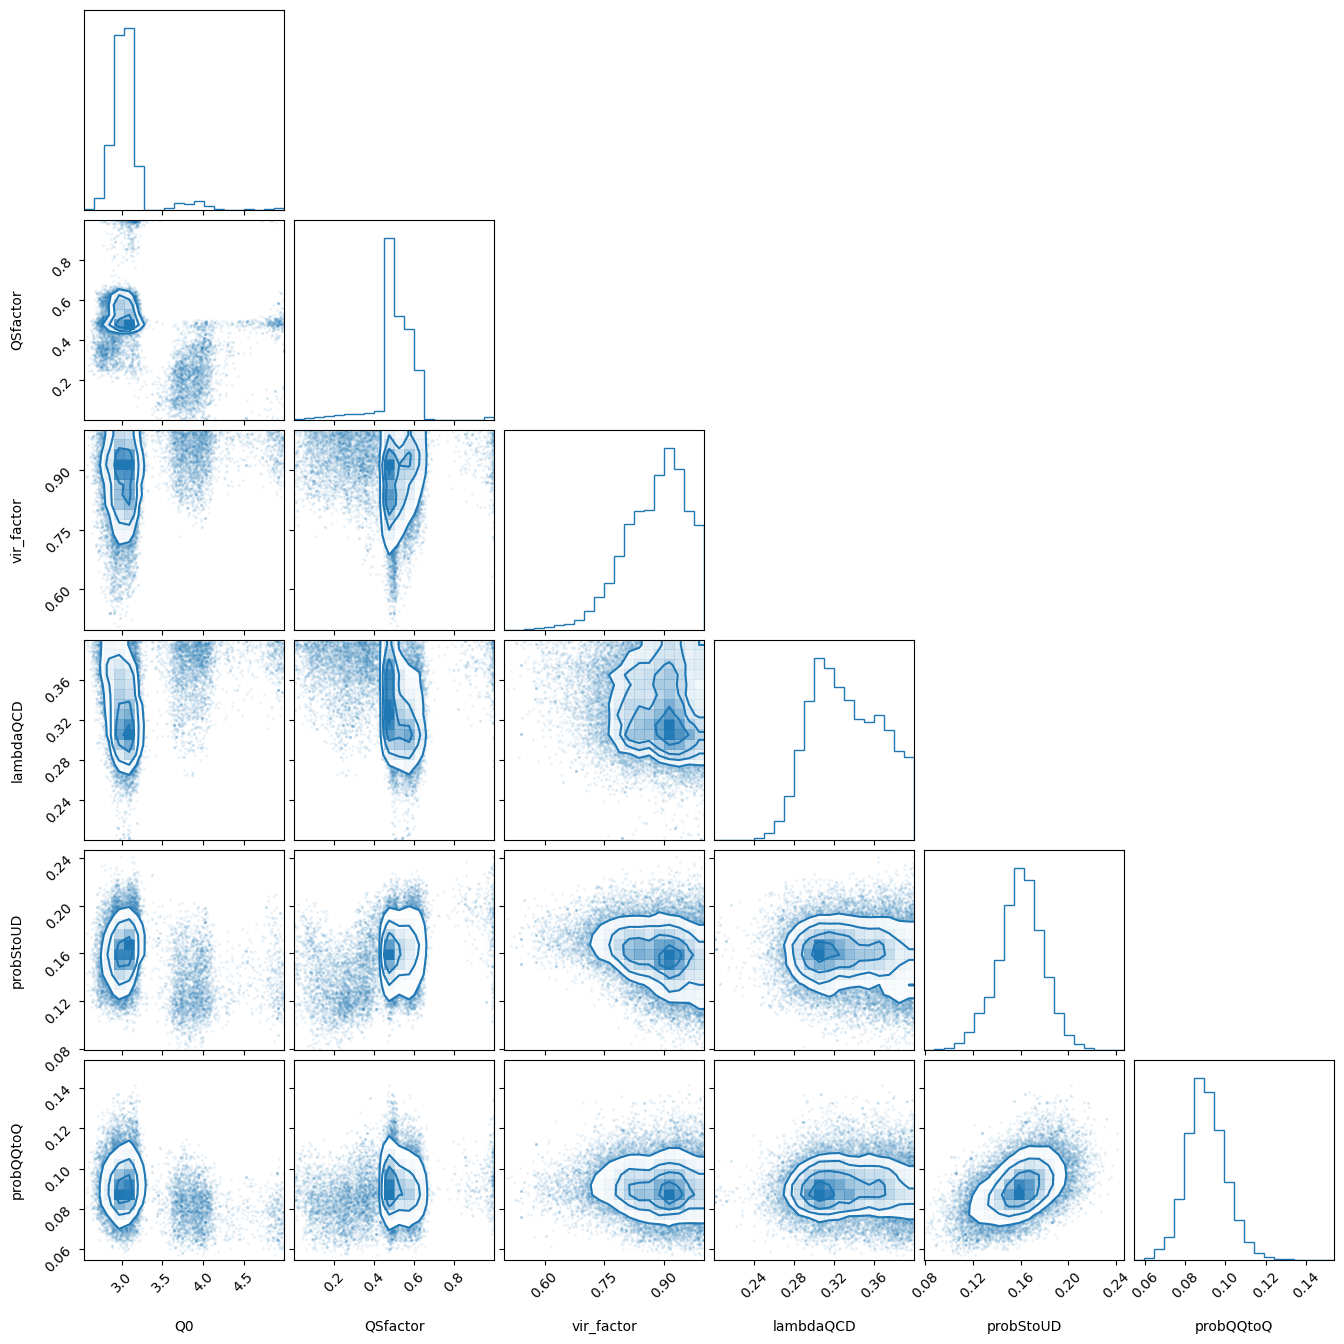

In [8]:
import pickle
import corner
import matplotlib.pyplot as plt
import numpy as np
        
with open('mcmc/chain.pkl', 'rb') as pf:
        data = pickle.load(pf)

labels = mymcmc.label

fig = corner.corner(data['chain'], weights=data['weights'], labels=labels, color="C0")
plt.show()

[WARNING][core] Too few points to create valid contours


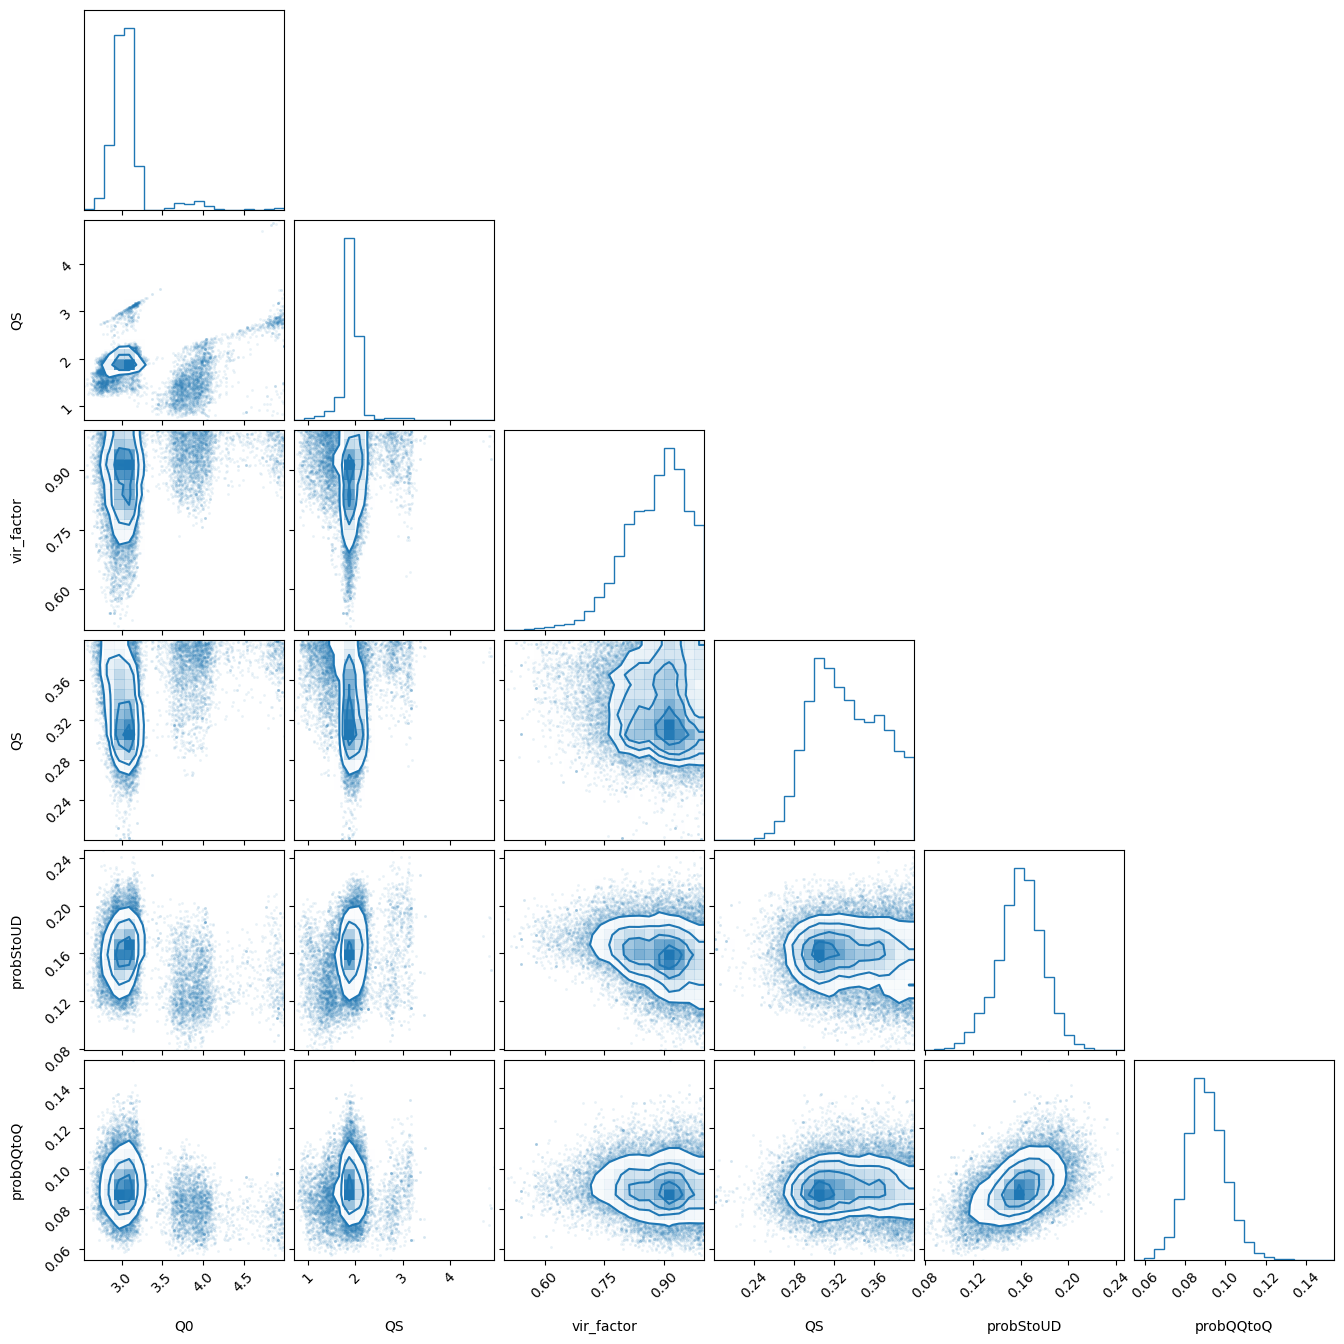

/home/rjfgroup/cameron.parker/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:382: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 162.52
differential_evolution step 2: f(x)= 136.885
differential_evolution step 3: f(x)= 136.885
differential_evolution step 4: f(x)= 131.403
differential_evolution step 5: f(x)= 131.403
differential_evolution step 6: f(x)= 131.403
differential_evolution step 7: f(x)= 131.403
differential_evolution step 8: f(x)= 131.403
differential_evolution step 9: f(x)= 131.403
differential_evolution step 10: f(x)= 131.06
differential_evolution step 11: f(x)= 131.06
differential_evolution step 12: f(x)= 128.496
differential_evolution step 13: f(x)= 128.496
differential_evolution step 14: f(x)= 128.496
differential_evolution step 15: f(x)= 128.496
differential_evolution step 16: f(x)= 128.496
differential_evolution step 17: f(x)= 128.496
differential_evolution step 18: f(x)= 128.496
differential_evolution step 19: f(x)= 127.583
differential_evolution step 20: f(x)= 127.063
differential_evolution step 21: f(x)= 126.562
differential_evolution step 22: f(x)= 126.562


In [13]:
TransformedSamples = np.copy(data['chain'])
TransformedSamples[:,0] = data['chain'][:,0]
TransformedSamples[:,1] = (2*data['chain'][:,3]+0.05) + (data['chain'][:,0]-(2*data['chain'][:,3]+0.05))*data['chain'][:,1]
TransformedSamples[:,2] = data['chain'][:,2]
TransformedSamples[:,3] = data['chain'][:,3]
TransformedSamples[:,4] = data['chain'][:,4]
TransformedSamples[:,5] = data['chain'][:,5]

labels[1] = "QS"
fig = corner.corner(TransformedSamples, weights=data['weights'], labels=labels, color="C0")
plt.show()
fig.savefig(outdir+'Corner.pdf', dpi = 192)

bestParams = ee_extract_parameters(mymcmc, ThisData["Design"]["Parameter"], outdir)

Priors

/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:228: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0][i].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements", color='black')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:229: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:229: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/fun

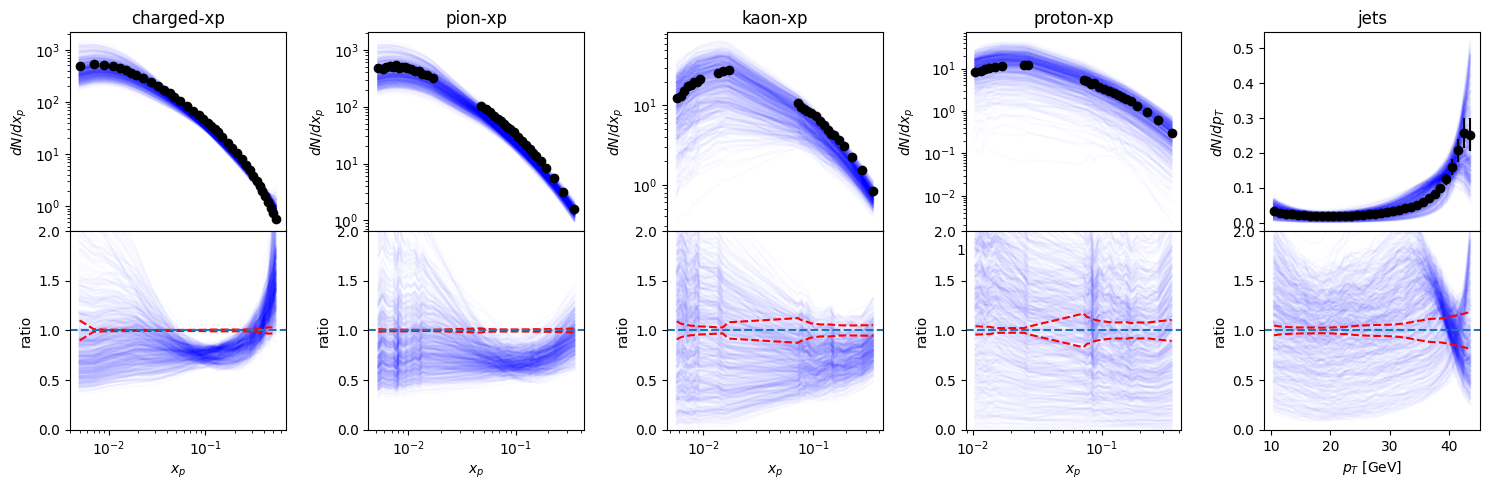

In [10]:
makeplot(ThisData, "Priors", outdir, logTrain=logTrain)

Posteriors

/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:228: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0][i].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements", color='black')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:229: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:229: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/fun

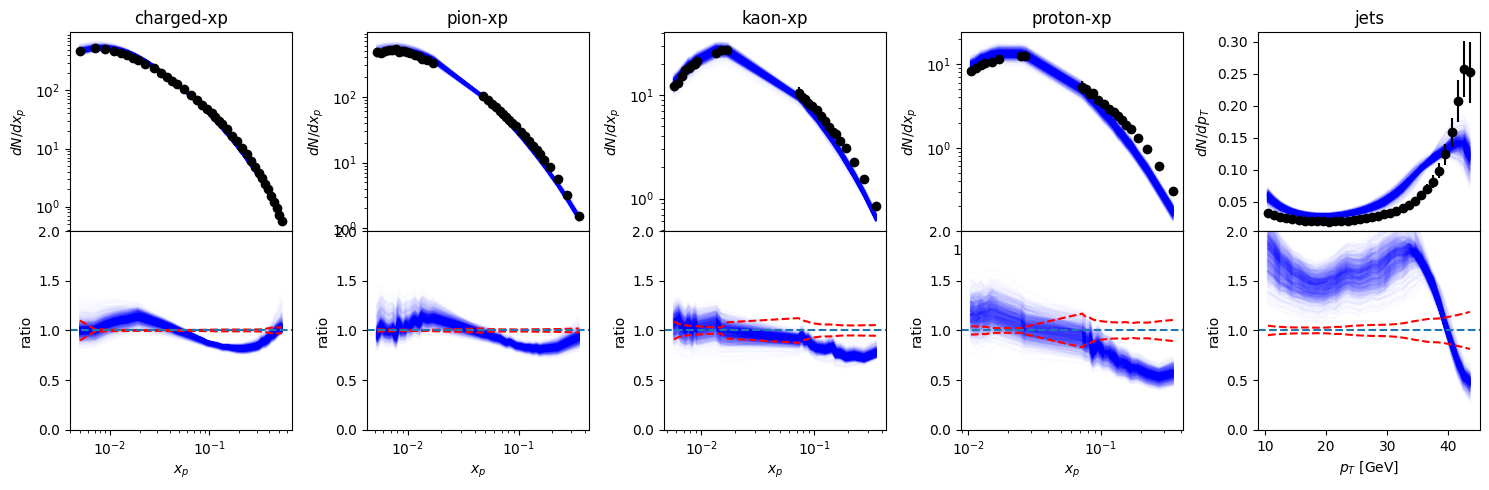

In [11]:
makeplot(ThisData, "Posteriors", outdir, samples=data["chain"], logTrain=logTrain)

Validation

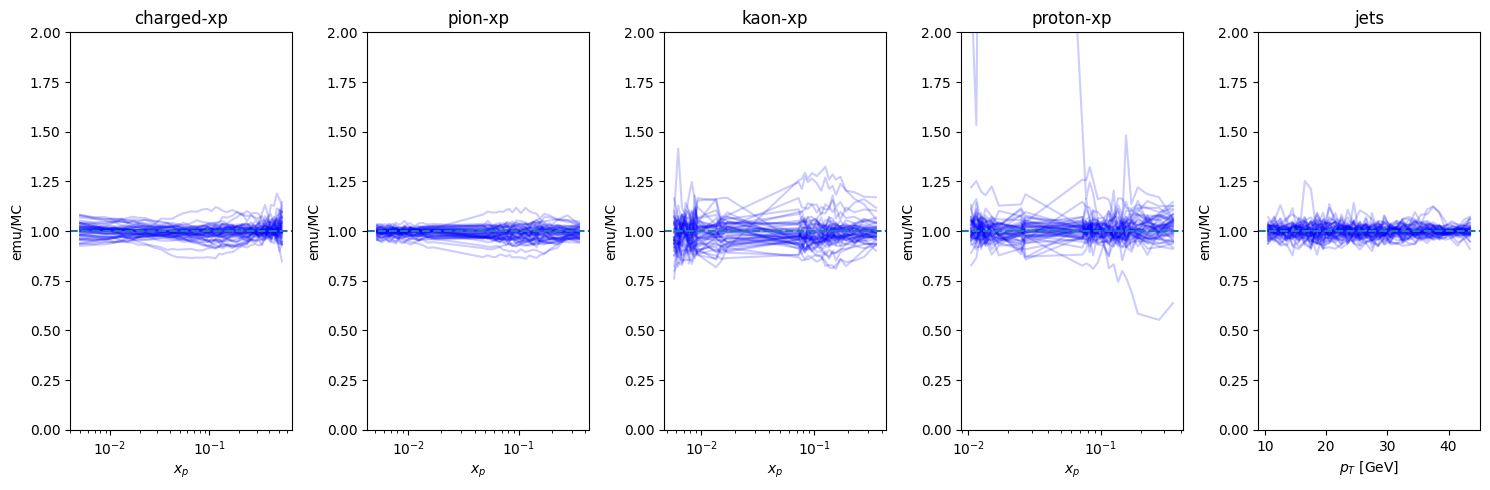

In [12]:
from src.data_objects import valData
valData["Design"] = ReadDesign("/data/rjfgroup/rjf01/cameron.parker/runs/validation/LEP/QVir_Analysis/parameters.txt")
trimRanges(valData)
validationPlots(valData, ThisData, outdir, logTrain=logTrain)